<a href="https://colab.research.google.com/github/afarahi/American-Housing-Survey-Study-/blob/main/KLLR-method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade git+https://github.com/afarahi/kllr.git
import kllr as kl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/afarahi/kllr.git to /tmp/pip-req-build-4ot4r6ya
  Running command git clone -q https://github.com/afarahi/kllr.git /tmp/pip-req-build-4ot4r6ya
  Created wheel for kllr: filename=kllr-2.101-py3-none-any.whl size=22269 sha256=9f8e7ede886428a8dda2911c532775c4e7522d38604b09f92a02a7fa8430fe03
  Stored in directory: /tmp/pip-ephem-wheel-cache-oo0jn44e/wheels/50/e7/a7/f524007bad32b1da64e26b0668f04029ca19e033679e74f214
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=bfaafe1a23cc9a83d8379233fe69f957f64529531718959c49081e18e699ad47
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built kllr sklearn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib

from scipy import stats
import xgboost

import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Data Preprocessing

Our data are from the 2019 American Housing Survey (AHS). AHS, the most comprehensive national housing survey in the U.S., is sponsored by the Department of Housing and Urban Development and conducted by the Census Bureau.

This study focuses on households who make more than \$10k and less than \$500k. Hence, the results are not generalizable to households with less than \$10k income. Additionally, since the gap nearly disappears for households with more than \$500k income, we discard them from our sample. After discarding non-respondents and households with income less than \$10k and more than \$500k, we end up with 48,660 households, of which 14\% are Black households.

Our aim is to quantify the factors that contribute to the homeownership gap In this study, we consider  household attributes, division, and the binary metropolitan area as control variables and a binary race as our main inference variable. We chose to work with log-income as an input to our model. No other transformation has been performed.



In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/afarahi/American-Housing-Survey-Study-/main/AHS-Data_2019_Cleaned.CSV', encoding='utf-8')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()


,BLACK,HHSEX,METRO,HHGRAD,HHMAR,HHCITSHP,HHAGE,NUMPEOPLE,HINCP,DIVISION,OWNER
0,0.0,1,1.0,44,1,1,52,3,257000,5,1.0
1,0.0,2,1.0,44,4,1,80,2,201000,1,1.0
2,0.0,1,1.0,47,1,1,72,2,66900,7,1.0
3,1.0,2,1.0,40,6,1,60,1,35000,4,0.0
4,0.0,2,1.0,39,3,1,80,2,20400,4,0.0


We set hyper-parameters of the KLLR method. Here we chose to work with the `kernel_width = 0.25`. But what does it mean?

In [ ]:
# Hyper-parameters
kernel_width = 0.25

# Motivation

We employ KLLR method to estiamted the expected homeownership likelihood at a function of income for each group, as discussed in the lecture. We use KLLR package to create the visualizations. The bootstrap procidure takes a few minutes. Be patient!

100%|██████████| 34/34 [00:01<00:00, 30.88it/s]


(0.0, 1.0)

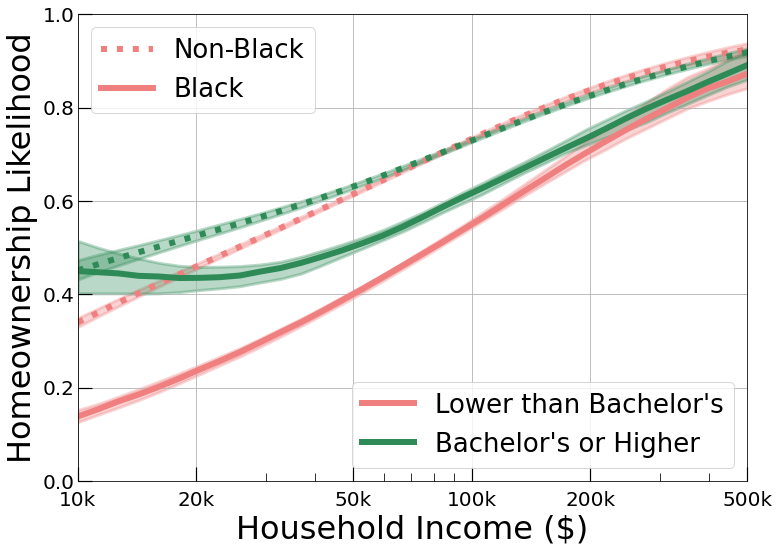

In [ ]:
_, ax = kl.Plot_Fit_Summary_Split(df[df['BLACK']==0.0], 'HINCP', 'OWNER', 'HHGRAD', split_bins=[29, 43.1,  50], split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7],
                           nBootstrap=500, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=1.5*kernel_width, fast_calc = False,
                           linestyle=':', black_line=False, alpha=1.0,
                           show_data=False, xlog=True, ylog=False, color=['lightcoral', 'seagreen','teal'], labels=['Household Income', 'Ownership Rate', 'X'])


_, ax = kl.Plot_Fit_Summary_Split(df[df['BLACK']==1.0], 'HINCP', 'OWNER', 'HHGRAD', split_bins=[29, 43.1,  50], split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7],
                           nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=1.5*kernel_width, fast_calc = False,
                           linestyle='-', black_line=False, alpha=1.0,
                           show_data=False, xlog=True, ylog=False, color=['lightcoral', 'seagreen','teal'], labels=['Household Income', 'Ownership Rate', 'X'], ax=ax)

ax.flat[1].set_visible(False)
ax.flat[2].set_visible(False)

ax[0].lines[0].set_label(None)
ax[0].lines[1].set_label(None)
ax[0].lines[2].set_label('Lower than Bachelor\'s')
ax[0].lines[3].set_label('Bachelor\'s or Higher')

for line in ax[0].get_lines()[:]: line.set_linewidth(6)


legend1 = ax[0].legend([ax[0].lines[0], ax[0].lines[2]], ["Non-Black", "Black"], prop={'size':26}, loc=2)
ax[0].add_artist(legend1)
ax[0].legend(loc=4, prop={'size':26})


ax[0].set_ylabel('Homeownership Likelihood', size=32)
ax[0].set_xlabel('Household Income ($)', size=32)
ax[0].tick_params(labelbottom=True)
ax[0].set_xticks([1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
ax[0].set_xticklabels(['10k', '20k', '50k', '100k', '200k', '500k'])
ax[0].set_xlim(1e4, 5e5)
ax[0].set_ylim(0.0, 1.0)

100%|██████████| 34/34 [00:01<00:00, 30.81it/s]


(0.0, 1.0)

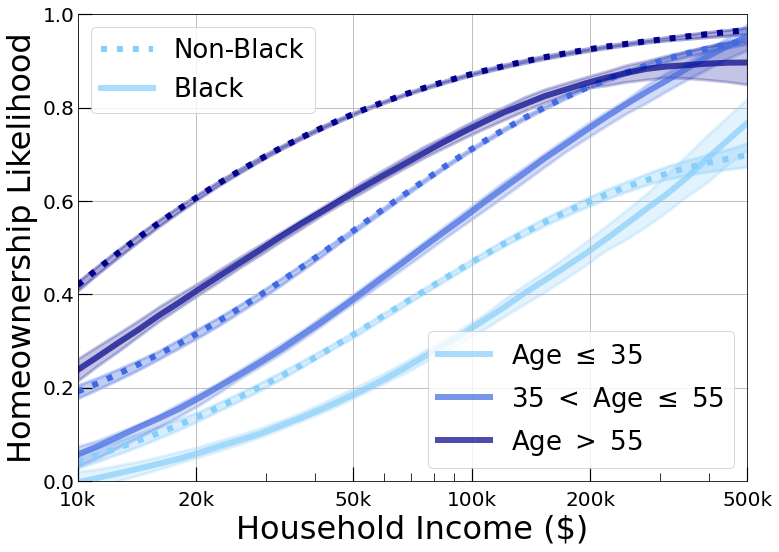

In [ ]:
_, ax = kl.Plot_Fit_Summary_Split(df[::][df['BLACK']==0.0], 'HINCP', 'OWNER', 'HHAGE', split_bins=[0.0, 35.5, 55.5, 120],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7],
                                  linestyle=':',  black_line=False,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=1.5*kernel_width, fast_calc = False,
                                  show_data=False, xlog=True, ylog=False, color=['lightskyblue', 'royalblue', 'darkblue'], labels=['Household Income', 'Ownership Rate', 'X'])

_, ax = kl.Plot_Fit_Summary_Split(df[::][df['BLACK']==1.0], 'HINCP', 'OWNER', 'HHAGE', split_bins=[0.0, 35.5, 55.5, 120],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7],
                                  linestyle='-',  black_line=False, alpha=0.7,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=1.5*kernel_width, fast_calc = False,
                                  show_data=False, xlog=True, ylog=False, color=['lightskyblue', 'royalblue', 'darkblue'], labels=['Household Income', 'Ownership Rate', 'X'], ax=ax)


ax.flat[1].set_visible(False)
ax.flat[2].set_visible(False)

ax[0].lines[0].set_label(None)
ax[0].lines[1].set_label(None)
ax[0].lines[2].set_label(None)
ax[0].lines[3].set_label(r'Age $\leq$ 35')
ax[0].lines[4].set_label(r'35 $<$ Age $\leq$ 55')
ax[0].lines[5].set_label(r'Age $>$ 55')

for line in ax[0].get_lines()[:]: line.set_linewidth(6)


legend1 = ax[0].legend([ax[0].lines[0], ax[0].lines[3]], ["Non-Black", "Black"], prop={'size':26}, loc=2)
ax[0].add_artist(legend1)
ax[0].legend(loc=4, prop={'size':26})


ax[0].set_ylabel('Homeownership Likelihood', size=32)
ax[0].set_xlabel('Household Income ($)', size=32)
ax[0].tick_params(labelbottom=True)
ax[0].set_xticks([1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
ax[0].set_xticklabels(['10k', '20k', '50k', '100k', '200k', '500k'])
ax[0].set_xlim(1e4, 5e5)
ax[0].set_ylim(0.0, 1.0)


# Machine Learning

In the economic and social sciences, parametric linear models, including logistic regression, are most often employed to study the association between household characteristics and tenure choice. Logistic regression has been the model of choice in most studies. While interpretable, they can miss complex interactions and non-monotonic relations between dependent and independent variables. Additionally, co-linearity between features can lead to spurious results. Previous studies sometimes discretized continuous variables (such as age and household income), which can induce estimation bias and make the interpretation harder and more prone to error. Instread we use a set of data-driven, interpretable machine learning models to capture the complex, non-linear patterns in homeownership and perform policy evaluation.  


In [ ]:
# define features and the target variables.
features = ['BLACK', 'HHSEX', 'METRO', 'HHGRAD', 'HHMAR', 'HHCITSHP', 'HHAGE', 'NUMPEOPLE', 'HINCP', 'DIVISION']
dependent_var = ['OWNER']

X = df[features]
y = df[dependent_var]

## model and hyper-parameter selection

We choose to only work with the ensemble decision-tree models. We compare a Random Forest and an eXtreme Gradient Boosting (XGBoost) using AUC criteria. For both models, the most sensitive hyper-parameter is `max_depth`, the maximum depth of the tree. We tune `max_depth`, and the test of hyper-parameters are the default sklearn parameters.

In [ ]:
max_depth_array = [2, 3, 4, 5, 6, 7, 8, 9, 10]

auc_mean = []
auc_std = []
for max_depth in max_depth_array:

    roc_auc_rf = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i*10 + 4)
        model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
        y_score = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc_rf += [auc(fpr, tpr)]

    print("max_depth %i -- AUC : %0.3f +- %0.3f"%(max_depth, np.mean(roc_auc_rf), np.std(roc_auc_rf)))
    auc_mean += [np.mean(roc_auc_rf)]
    auc_std += [np.std(roc_auc_rf)]

<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = R

max_depth 2 -- AUC : 0.758 +- 0.004


<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = R

max_depth 3 -- AUC : 0.786 +- 0.003


<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = R

max_depth 4 -- AUC : 0.799 +- 0.004


<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = R

max_depth 5 -- AUC : 0.807 +- 0.003


<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = R

max_depth 6 -- AUC : 0.813 +- 0.003


<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = R

max_depth 7 -- AUC : 0.818 +- 0.003


<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = R

max_depth 8 -- AUC : 0.821 +- 0.003


<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = R

max_depth 9 -- AUC : 0.822 +- 0.003


<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
<ipython-input-12-c40ed21792b9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = R

max_depth 10 -- AUC : 0.822 +- 0.003


In [ ]:
max_depth_array = [2, 3, 4, 5, 6, 7, 8, 9, 10]

auc_xg_mean = []
auc_xg_std = []
for max_depth in max_depth_array:

    roc_auc_rf = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i*10 + 4)
        model = xgboost.XGBRegressor(max_depth=max_depth).fit(X_train, y_train)
        y_score = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc_rf += [auc(fpr, tpr)]

    print("max_depth %i -- AUC : %0.3f +- %0.3f"%(max_depth, np.mean(roc_auc_rf), np.std(roc_auc_rf)))
    auc_xg_mean += [np.mean(roc_auc_rf)]
    auc_xg_std += [np.std(roc_auc_rf)]

[18:36:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

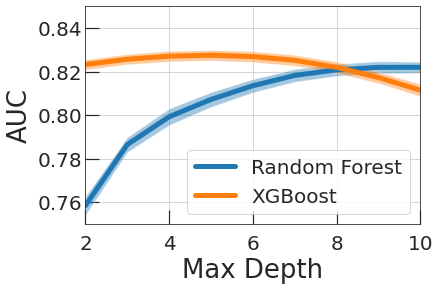

In [ ]:
sns.set_style("ticks", {'axes.facecolor': 'white',  'figure.facecolor': 'white', 'legend.fontsize': 30, "xtick.direction": "in","ytick.direction": "in"})

plt.plot(max_depth_array, auc_mean, lw=5.0, label='Random Forest')
plt.fill_between(max_depth_array, np.array(auc_mean)+auc_std,  np.array(auc_mean)-auc_std, alpha=0.4)

plt.plot(max_depth_array, auc_xg_mean, lw=5.0, label='XGBoost')
plt.fill_between(max_depth_array, np.array(auc_xg_mean)+auc_xg_std,  np.array(auc_xg_mean)-auc_xg_std, alpha=0.4)


plt.legend(loc=4, prop={'size':20})
plt.ylabel('AUC', size=26)
plt.xlabel('Max Depth', size=26)
plt.xlim(2, 10)
plt.ylim(0.75, 0.85)
plt.grid()


Show AUC curve for both models

In [ ]:
fpr_array = []
tpr_array = []
roc_auc_rf = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i*10 + 4)
    model = RandomForestRegressor(max_depth=9).fit(X_train, y_train)
    y_score = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    fpr_array += [fpr]
    tpr_array += [tpr]
    roc_auc_rf += [auc(fpr, tpr)]

df_rf = pd.DataFrame({'fpr':np.concatenate(fpr_array).ravel(), 'tpr':np.concatenate(tpr_array).ravel()})

print(roc_auc_rf)
print("AUC : %0.3f +- %0.3f"%(np.mean(roc_auc_rf), np.std(roc_auc_rf)))

<ipython-input-15-7910cd697fa9>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=9).fit(X_train, y_train)
<ipython-input-15-7910cd697fa9>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=9).fit(X_train, y_train)
<ipython-input-15-7910cd697fa9>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=9).fit(X_train, y_train)
<ipython-input-15-7910cd697fa9>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_dep

[0.8196282188531198, 0.8203090736001294, 0.8192893631018654, 0.8259076458758494, 0.8237670130528782, 0.8195737782568927, 0.8188094838239706, 0.8250529733289024, 0.8183668344562959, 0.8261305695416629]
AUC : 0.822 +- 0.003


In [ ]:
fpr_array = []
tpr_array = []
roc_auc_xgboost = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i*10 + 4)
    model = xgboost.XGBRegressor(max_depth=5).fit(X_train, y_train)
    y_score = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    fpr_array += [fpr]
    tpr_array += [tpr]
    roc_auc_xgboost += [auc(fpr, tpr)]

df_xgboost = pd.DataFrame({'fpr':np.concatenate(fpr_array).ravel(), 'tpr':np.concatenate(tpr_array).ravel()})

print(roc_auc_xgboost)
print("AUC : %0.3f +- %0.3f"%(np.mean(roc_auc_xgboost), np.std(roc_auc_xgboost)))

[18:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

100%|██████████| 50/50 [00:00<00:00, 133.96it/s]


(0.0, 1.0)

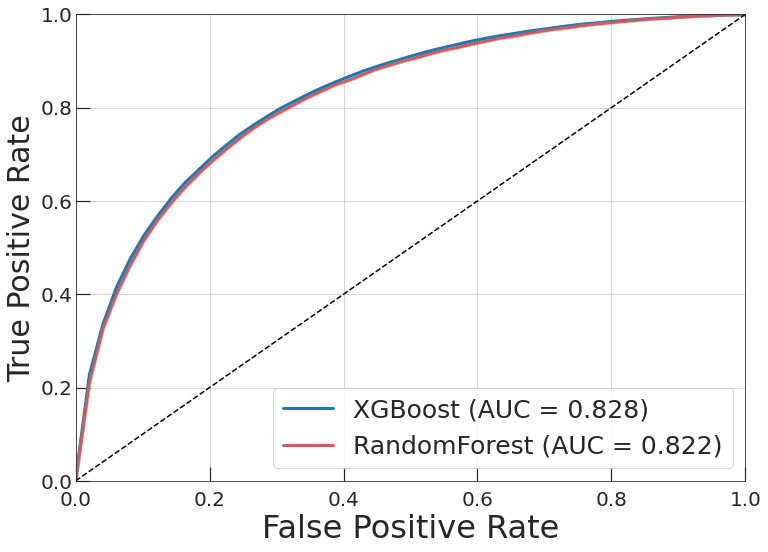

In [ ]:
_, ax = kl.Plot_Fit_Summary(df_xgboost, 'fpr', 'tpr', bins=50, xrange=[0.0, 1.0],
                            nBootstrap=1, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.001,
                            linestyle='-', black_line=False, show_data=False, xlog=False, ylog=False, color=None,
                            labels=['False Positive Rate', 'True Positive Rate'])

_, ax = kl.Plot_Fit_Summary(df_rf, 'fpr', 'tpr', bins=50, xrange=[0.0, 1.0],
                            nBootstrap=1, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.001,
                            linestyle='-', black_line=False, show_data=False, xlog=False, ylog=False, color='indianred',
                            labels=['False Positive Rate', 'True Positive Rate'], ax=ax)

ax[0].plot([0.0, 1.0], [0.0, 1.0], '--', color='black')

ax.flat[1].set_visible(False)
ax.flat[2].set_visible(False)


ax[0].lines[0].set_label('XGBoost (AUC = %0.3f)'%np.mean(roc_auc_xgboost))
ax[0].lines[1].set_label('RandomForest (AUC = %0.3f)'%np.mean(roc_auc_rf))
ax[0].legend(loc=4, prop={'size':25})

ax[0].set_xlabel('False Positive Rate', size=32)
ax[0].tick_params(labelbottom=True)
ax[0].set_xlim(0.0, 1.0)
ax[0].set_ylim(0.0, 1.0)

After hyper-parameter tuning of both models, XGBoost outperforms Random Forest. AUC for the tuned XGBoost and Random Forest are $0.828 \pm 0.003$ and $0.822 \pm 0.003$, respectively. While the difference between their performance is small, this difference is statically significant. Thus, we choose either XGBoost with `max_depth` = 5 or Random Forest with `max_depth` = 9 as our baseline model.


Now, what about interpretability, is race an important factor? Does race contributes to the homeownership likelihood? by how much? does this contribution changes with group memebrship? These are the questions we want to answer next.

# Methods of Global Interpretability

In [ ]:
model = RandomForestRegressor(max_depth=9).fit(X, y)

<ipython-input-18-84e4c7a0bee9>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=9).fit(X, y)


# Partial Dependence Plots


In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
features_PDP = ['HINCP'] # ['BLACK', 'HHSEX', 'METRO', 'HHGRAD', 'HHMAR', 'HHCITSHP', 'HHAGE', 'NUMPEOPLE', 'HINCP', 'DIVISION']
features_PDP_2D = [('HINCP', 'NUMPEOPLE')]

<Figure size 720x720 with 0 Axes>

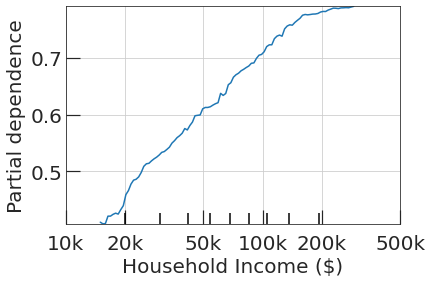

In [ ]:
plt.figure(figsize=(10,10))
PartialDependenceDisplay.from_estimator(model, X, features_PDP, kind='average')
plt.xticks(np.log10([1e4, 2e4, 5e4, 1e5, 2e5, 5e5]), ['10k', '20k', '50k', '100k', '200k', '500k'])
plt.ylabel('Partial dependence', size=20)
plt.xlabel('Household Income ($)', size=20)
plt.grid()

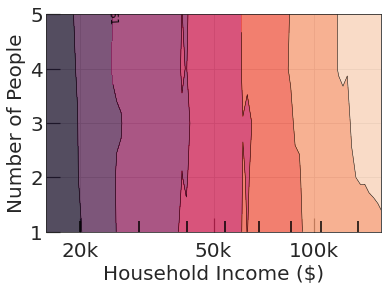

In [ ]:
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, kind='average')
plt.xticks(np.log10([1e4, 2e4, 5e4, 1e5, 2e5, 5e5]), ['10k', '20k', '50k', '100k', '200k', '500k'])
plt.ylabel('Number of People', size=20)
plt.xlabel('Household Income ($)', size=20)
plt.xlim(4.2, 5.2)
plt.ylim(1.0, 5.0)

plt.grid()

**How do you interpret this plot?**

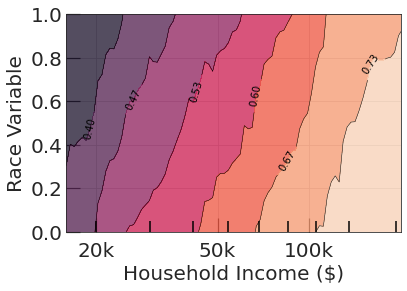

In [ ]:
features_PDP_2D = [('HINCP', 'BLACK')]

PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, kind='average')
plt.xticks(np.log10([1e4, 2e4, 5e4, 1e5, 2e5, 5e5]), ['10k', '20k', '50k', '100k', '200k', '500k'])
plt.ylabel('Race Variable', size=20)
plt.xlabel('Household Income ($)', size=20)
plt.xlim(4.2, 5.3)
plt.ylim(0, 1.0)

plt.grid()

# Accumulated Local Effects (ALE) Plot


Accumulated local effects describe how features influence the prediction of a machine learning model on average. ALE plots are a faster and unbiased alternative to partial dependence plots (PDPs).

If features of a machine learning model are correlated, the partial dependence plot cannot be trusted. The computation of a partial dependence plot for a feature that is strongly correlated with other features involves averaging predictions of artificial data instances that are unlikely in reality. This can greatly bias the estimated feature effect.

In [ ]:
!pip install PyALE

# check out the tutorial here: https://github.com/DanaJomar/PyALE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PyALE import ale

INFO:PyALE._ALE_generic:Continuous feature detected.


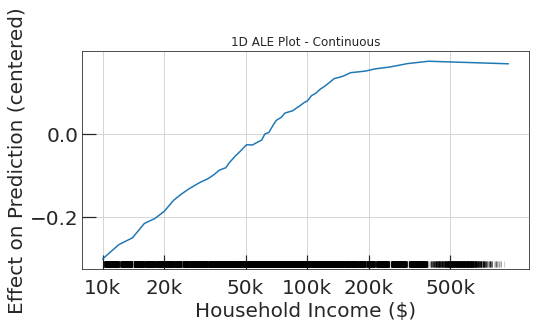

In [ ]:
ale_eff = ale(X=X[features], model=model, feature=features_PDP, grid_size=50, include_CI=False)
plt.xticks(np.log10([1e4, 2e4, 5e4, 1e5, 2e5, 5e5]), ['10k', '20k', '50k', '100k', '200k', '500k'])
plt.ylabel('Effect on Prediction (centered)', size=20)
plt.xlabel('Household Income ($)', size=20)
plt.grid()

hmmmm!?

/usr/local/lib/python3.8/dist-packages/PyALE/_src/ALE_2D.py:145: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  (
/usr/local/lib/python3.8/dist-packages/PyALE/_src/ALE_2D.py:161: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  (


<Figure size 720x720 with 0 Axes>

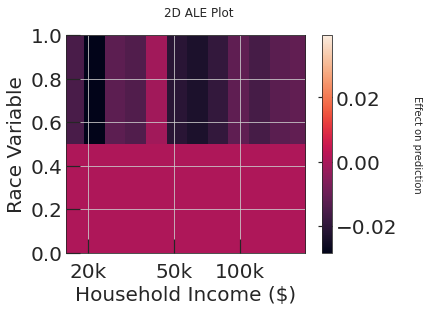

In [ ]:
## 2D - continuous
features_2D = ['BLACK', 'HINCP']
plt.figure(figsize=(10,10))
ale_eff = ale(X=X[features], model=model, feature=features_2D, grid_size=20)

plt.xticks(np.log10([1e4, 2e4, 5e4, 1e5, 2e5, 5e5]), ['10k', '20k', '50k', '100k', '200k', '500k'])
plt.ylabel('Race Variable', size=20)
plt.xlabel('Household Income ($)', size=20)
plt.xlim(4.2, 5.3)
plt.ylim(0, 1.0)

plt.grid()